# Acoustic Positioning System (Remote) Solutions

### EECS16A: Designing Information Devices and Systems I, Fall 2022

# Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Introduction](#overview)
    * [Basic Principles of Operation](#bpo)
    * [Overview](#background)

* [Task 1: Measuring the Similarity of Two Signals](#task1)
* [Task 2: Extracting information](#task2)
* [Task 3: Detecting Real Signals](#task3)
* [Task 4: Separating Signals and Beacons](#task4)
* [Task 5: Computing Distances](#task5)
    * [Task 5a: Identifying Offsets](#task5a)
    * [Task 5b: Combining Functions](#task5b)
* [Task 6: Constructing and Solving a System of Equations](#task6)
    * [Task 6a: Constructing the System](#task6a)
    * [Task 6b: Approximating a Solution with Least Squares](#task6b)
    * [Task 6c: Simulation Testing](#task6c)
    * [Task 6d: Real Life Positioning](#task6d)
* [Checkoff](#checkoff)
    
<a id='instructions'></a>
## Instructions

* **Gently disinfect all commonly touched surfaces** at your lab station using the provided cleaning wipes.


* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.


* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.


* Labs will be graded based on completion for teams of 2 students.

<a id='policies'></a>
## Lab Policies
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are required to return all parts checked out at the beginning of the lab section unless told otherwise.**
* **You are free to stay for the full allotted time and hack around with the lab equipment, but please reserve the GSI's time for lab-related questions.**
* **Food and drinks are not allowed in the lab.** 
* **Clean up, turn off all equipment, and log off of computers before leaving.**

## Introduction

This lab is all software and done entirely in this Jupyter notebook.

We use various positioning systems every day. The most commonly used such system is the [Global Positioning System (GPS)](http://en.wikipedia.org/wiki/Global_Positioning_System). The navigation systems in cars, Google Maps, cell phones, and even rockets and spaceships all use GPS.

In this lab, we are going to explore basic navigation systems and build our own. At the end of this lab, you will have written software (and tested it on real data) that can determine the location of a receiver in 2D space!
### Run the cell below to import the necessary helper functions.

In [1]:
%pylab inline
%run support_code/APS.py
%run support_code/helper_functions.py

Populating the interactive namespace from numpy and matplotlib


<a id='bpo'></a>
## Basic Principles of Operation
GPS satellites broadcast a variety of measurements such as the satellite's position and velocity, as well as time, using a very precise clock. GPS receivers make use of the fact that light propagates at a known speed: $3\times 10^8 ms^{-1}$. A receiver can therefore compute its distance to the satellite by measuring how long it takes the GPS signal to travel from the satellite to the receiver, using the speed of light and the known time that the signal was broadcasted from the satellite.

<br>
<center>
<img src="img/wk1_standard_gps.png" align="center" style="height:250px">
    
**Source**: [Kathleen Cantner, AGI](http://www.earthmagazine.org/article/precise-fault-how-gps-revolutionized-seismic-research)
</center>

We will instead explore an Acoustic Positioning System, using speakers as signal emitters to emit sound (the signal), and using microphones as receivers. We can similarly determine the distance to each emitter based on the delay between the times at which we receive each signal. We will explore this idea further through the course of this lab.

<a id='background'></a>
## Overview
The block diagram below describes the system at a high level. 
<br>
First, each speaker transmits a unique signal. The combined signal from all speakers is then recorded by the microphone and converted to a format that is convenient for further processing. 
<br>
Next, the component signal from each speaker is identified from the received total signal using cross-correlation analysis, and the corresponding time differences are used to determine the receiver's location.

<center>
<img src="img/signals.png" align="center" style="height:450px">
</center>

<a id='task1'></a>
## <font color="blue">Task 1: Measuring the Similarity of Two Signals
    
Our APS setup will use multiple speakers as 'beacons' to emit signals, and a single microphone receiver. The receiver will receive the sum of all the emitted signals at various delays, depending on the relative distances between the speakers and microphone. To identify each speaker's emitted signal from the received signal, as well as the time delay associated with each component, we will use **cross-correlation** analysis. In particular, the combined received signal will be cross correlated with stored copies of **each** speaker's unique emitted signal.

**[Cross-correlation](http://en.wikipedia.org/wiki/Cross-correlation)** is a measure of similarity between two functions - in this case these 'functions' will be vectorized time domain signals. It is a mathematical operation defined by taking successive inner products as one vector 'slides past the other', roughly speaking. Intuitively this is a measure of the 'overlap' between two signals as one signal is shifted in time. For discrete signals, the 'overlap' at time $t$ of the received signal and a copy of a particular speaker generated signal is the inner product of the received signal at that time and a shifted version of the stored copy. Both a mathematical definition and an animation are shown below where $x$ and $y$ are real valued functions.

You have learned how to calculate the linear cross-correlation between two generic signals. Recall that for two signals $x$ and $y$, the $m^{th}$ element of the linear cross-correlation vector $\vec{\rho_{xy}}$ is defined below:  

$$corr_{\vec{x}}(\vec{y})[m]=\vec{\rho_{xy}}[m] \stackrel{\mathrm{def}}{=} \sum_{n=-\infty}^{\infty} x[n] y[n-m]$$

<img src="img/square_triangle_xcorr.gif" border="0" alt="Animation demonstrating cross-correlation." style="height:300px">
<!--- <img src="img/cross_correlation_animation_auto-tune.gif" border="0" alt="Animation demonstrating cross-correlation."> --->

$\rho_{xy}[m]$ is the inner product of two vectors that have been zero-padded: $\vec{x}[n]$ and $\vec{y}[n-m]$, where $m$ is an integer between $-\infty$ to $\infty$. $\vec{y}[n-m]$ is $\vec{y}$ delayed by $m$ discrete time steps. In the above animation, the red signal is shifted by various time steps. The value of the black signal at a particular time is the inner product of the shifted red signal at the corresponding time shift and the blue signal. Observe that the red signal has been zero-padded on both sides to match the length of the blue signal. The blue signal is also zero-padded such that the correlation vector (black) contains entries for all valid overlaps between the two signals.

In this lab we will be using a variant of linear cross-correlation called **periodic linear cross-correlation**. The difference between finite linear cross-correlation and periodic cross-correlation is that <span style='color:red'><b> we treat the stationary signal as repeating infinitely in time.</b></span>  The original stationary signal is effectively padded with a copy of itself infinitely many times. 

**Run the code below to view a demo of how periodic cross-correlation works. The demo shows the inputs and outputs to a periodic cross-correlation function, as well as the relevant shifts and periodicity of the involved signals. The plots show one period of cross-correlation.**

periodic stationary signal:[ ... 1 2 3 2 1 0 1 2 3 2 1 0 1 2 3 2 1 0 ...]
sliding signal: [3 1 0 0 0 1]
periodic cross-correlation:[ ... 5 10 13 10 5 2 5 10 13 10 5 2 5 10 13 10 5 2 ...]


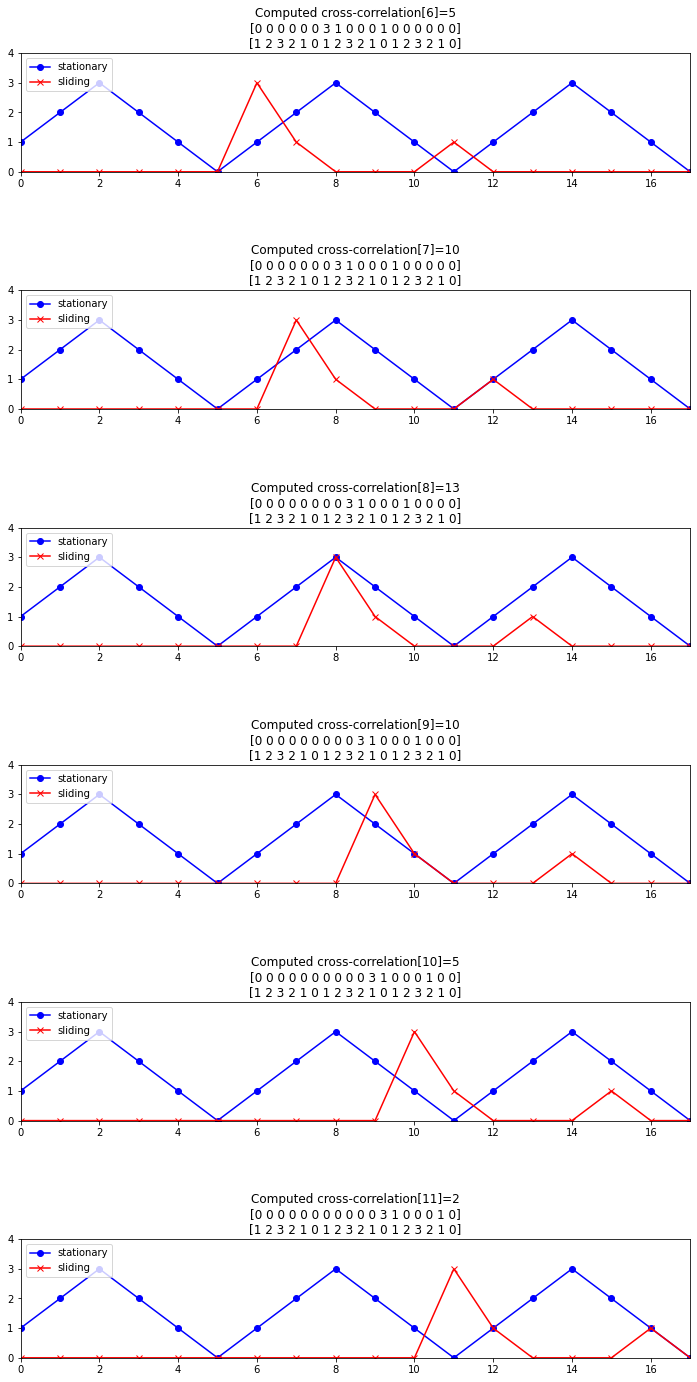

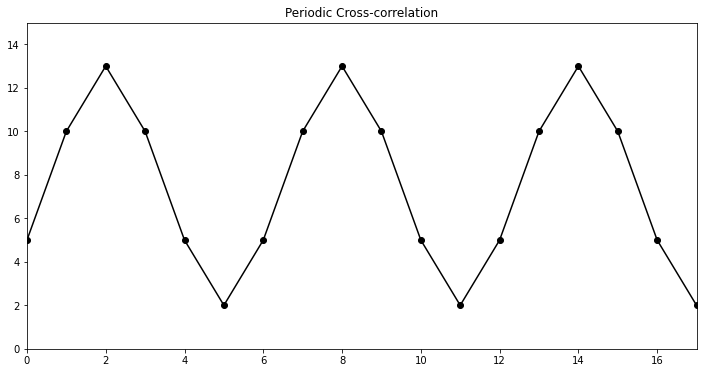

In [2]:
cross_corr_demo()

In the above example with $\vec{x} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 0\end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} 3 & 1 & 0 & 0 & 0 & 1\end{bmatrix}^T$, one period of the resultant periodic cross-correlation vector is:

$$ v = \begin{bmatrix} 5 \\ 10 \\ 13 \\ 10 \\ 5 \\ 2 \end{bmatrix} $$

Where $$ v[0] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix}, \begin{bmatrix} 3 \\ 1 \\ 0 \\ 0 \\ 0 \\ 1 \end{bmatrix} \right> = 5 \hspace{15pt} v[1] = \left< \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 \\ 3 \\ 1 \\ 0 \\ 0 \\ 0\end{bmatrix} \right> = 10 \hspace{15pt} ... $$ and so on.


**<font color="red"> Based on the cross-correlation plot, by how many samples (and in which direction) should the red signal be shifted to maximize the cross-correlation between the two signals?** 

It should be shifted to the right by 2 units.

**NOTE**: In the real world, we might cross correlate over multiple periods of $\vec{x}$ (the stationary signal). This is because $\vec{x}$ may not be perfectly $N$-periodic due to noise affecting values of the signal at certain times. We compensate by using multiple periods of the signal when calculating cross-correlations so that we have multiple periods of the cross-correlation data. These periods can then be averaged to return a good approximation of the noise free data. Data redundancy for noise reduction will be explored later in this lab.


**Below, you are given a cross-correlation function that performs periodic cross-correlation on two signals using `np.correlate`.**
    
```python
def cross_correlation(stationary_signal, sliding_signal):
    """Compute the cross_correlation of two given signals    
    Args:
    stationary_signal (np.array): input signal 1
    sliding_signal (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): periodic cross-correlation of stationary_signal and sliding_signal
    
    >>> cross_correlation([0, 1, 2, 3], [0, 2, 3, 0])
    [8, 13, 6, 3]
    """
    inf_stationary_signal = np.concatenate((stationary_signal, stationary_signal))
    entire_corr_vec = np.correlate(inf_stationary_signal, sliding_signal, 'full')
    return entire_corr_vec[len(sliding_signal)-1: len(sliding_signal)-1 + len(sliding_signal)]

```



Run the following cell to display an interactive plot of `stationary_signal`, `sliding_signal`, and the resulting periodic linear cross-correlation vector. Set the offset slider to different values to visualize the "periodic" part of the stationary signal and understand the relationship between the offset and correlation result. **Note: to avoid lag, click on the slider to reposition it instead of dragging.**

In [3]:
inf_periodic_cross_corr()

interactive(children=(IntSlider(value=0, description='offset', max=8, min=-8), Output()), _dom_classes=('widge…

**Notice that the value of correlation (on the y axis of the lower subplot) is highest when the orange and blue signals overlap the most. Similarly, the value is lowest when the signals overlap the least.** This elucidates how cross-correlation measures the similarity between two signals at different time shifts.

<a id='task2'></a>
## <font color="blue">Task 2: Extracting Information

The acoustic positioning system we will design uses speakers as *beacons* that each transmit a (known) unique *beacon signal*. The beacon signals will be used to determine the position of a *receiver* - a microphone. Figure 3a shows examples of waveforms generated by a two beacon system. The beacons are synchronized, i.e all beacon signals are transmitted from their respective beacons simultaneously. Figure 3b demonstrates an example of a  receiver that is further away from beacon 2 than beacon 1, consequently receiving the beacon signal from beacon 2 **after** the beacon signal from beacon 1.


<img src="img/Slide2.tiff.png" width=700px></img>
<h4><center>Figure 3</center></h4>

The raw signal that the receiver measures shown in Figure 4a (black), is a superposition of beacon signal 1 and a delayed beacon signal 2. We can cross-correlate this received signal  with stored copies of each unique beacon signal to determine when each beacon signal arrived at the receiver. For a given beacon signal, this will be the time index that corresponds to the maximum cross-correlation with the stored copy of that particular beacon signal. 

<img src="img/Slide3.tiff.png" width=700px></img>
<h4><center>Figure 4</center></h4>

Notice that in Figure 4b, the cross-correlation of the received signal with a stored copy of beacon signal 1 attains its maximum 3 milliseconds **before** the cross-correlation of the received signal with beacon signal 2 is maximized. We can therefore infer that beacon signal 1 was received 3 milliseconds before beacon signal 2, and that the distance of the microphone from the first beacon is less than the distance of the microphone from the second beacon.

Although the two beacon signals are different, notice that the cross-correlation **between the two beacon signals** is still non-zero. This is fine for our purposes, and will still allow for robust identification of beacon signals. In particular we only require that:

* The cross-correlation **between different beacon signals** is **small**.
* The cross-correlation of a beacon signal with itself (autocorrelation) is **small** for **non zero shifts**. 
* The autocorrelation of a beacon signal with itself is **large** at **zero shift**.

If these conditions hold, we can still identify the beacon signals that a received signal is composed of, since the cross-correlation between a beacon signal and the received signal at the correct offset (i.e where the overlap between the beacon signal and the corresponding component in the received signal is maximized) will always be considerably larger than other cross-correlation values. 

Real Global Positioning Systems deal with this problem by using pseudorandom binary sequences (signals composed of just 1s and 0s), also known as **Gold Codes**, constructed with the three properties described above. The theory and implementation of these signals is beyond the scope of this class. We have provided a large set of Gold Codes that are designed to work well for our purposes. 

Run the next cell to simulate three beacons that each produce a unique gold code.

In [4]:
sliderPlots()

interactive(children=(IntSlider(value=0, description='delay_samples0', max=500, min=-500, step=10, style=Slide…

The sliders control the delay of each beacon (in units of samples). Experiment with the delay values for each beacon and observe how the cross-correlation plot changes. If the slider does not appear or work for some reason, you can manually change the values in the tuples for `delay_samples0`, `1`, and `2`. For example, try `delay_samples0 = (-300, 400, 10)` and see how the plot changes.

**<font color="red">Pick some non-zero values for the sliders and comment on the offset corresponding to maximum cross-correlation. What is the relationship between the offset (from the cross-correlation plot at the bottom) and the delay (set using the sliders) for this part?**

The offset corresponding to maximum cross-correlation is the delay.

If you are given some beacon signals (gold codes) and a received signal that is a composition of these gold codes at different delays, how would you calculate when (in samples) each beacon signal arrived at the receiver?

**<font color="red">Implement a helper function `identify_peak` which takes in a signal with a single global maximum as an input and returns the index of this global maximum.** <font color="red">Note that the signals are zero-indexed, as shown in the example input and output of the function below.

In [6]:
def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    return np.argmax(signal)

**<font color="red">Verify the following test for `identify_peak`.**

In [7]:
test(cross_correlation, identify_peak, 2)

Test 2 Identify peaks Passed: Your peaks [3,4], Correct peaks [3,4]


<a id='task3'></a>
# <font color="blue">Task 3: Detecting Real Signals

We will now test the functions you have written with real data.

For your convenience, we have pre-recorded some audio samples for you to use from the real setup that you will use toward the end. The code block below will load a test signal (in blue) and test the code you have written, displaying the signal cross correlated with four known signals. This might take a while ($\approx 30$ seconds).

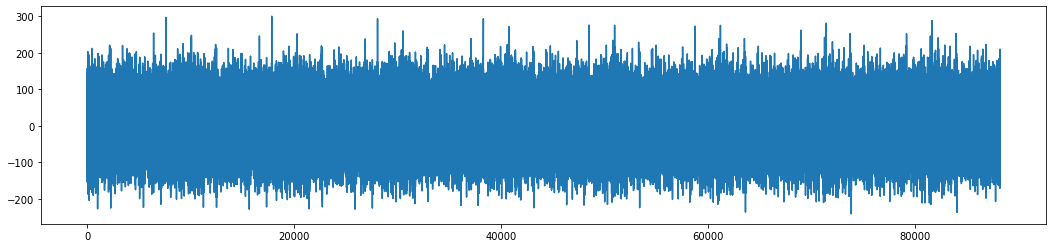

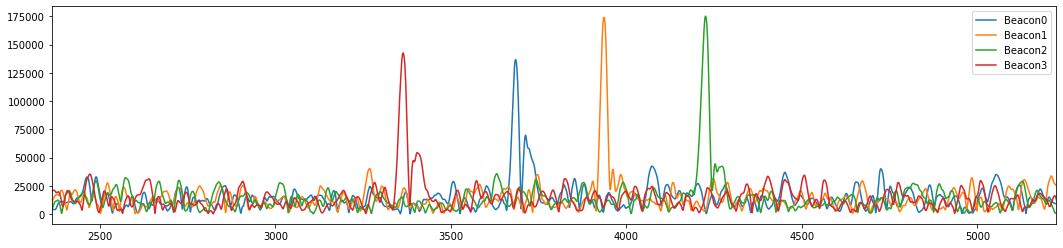

In [8]:
Lab.rawSignal = np.load('sig.npy')
Lab.load_corr_sig(identify_peak)

You should see four discernible peaks after cross-correlating the signals. 

<a id='task4'></a>
# <span style="color:blue">Task 4: Separating Signals and Beacons</span>

Recall that we only have a single receiver (microphone) receiving signals from multiple beacons (speakers). We use periodic cross-correlation to determine the time (in units of samples) at which each signal arrives after some reference time. This process is called *signal separation*. We have provided you with the following function to do this:

```python
def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals.

    Args:
    raw_signal (np.array): raw signal from the microphone composed of multiple beacon signals
    
    Returns (list): each entry should be the cross-correlation of the signal with one beacon
    """
    Lperiod = len(beacon[0])
    Ncycle = len(raw_signal) // Lperiod
    for ib, b in enumerate(beacon):
        c = cross_correlation(raw_signal[0:Lperiod],b)
        # Iterate through cycles
        for i in range(1,Ncycle):
            c = np.hstack([c, cross_correlation(raw_signal[i*Lperiod:(i+1)*Lperiod], b)])
        if (ib==0): cs = c
        else:       cs = np.vstack([cs, c])
    return cs
```

Before moving on to converting between time delays and positions, you should first consider several potential issues with this model for a positioning system:

1. The beacons play on a loop at a fixed rate. However, as the receiver is not synchronized with the rest of the beacons, we do not know when in the loop we started recording the beacon signals on the receiver. If we record for exactly the number of samples in one period of a beacon signal, we most likely started recording after some portion of the beacon signal has already been transmitted.
<br/> <br/>
It turns out that since our system uses periodic signals, it doesn't matter where we start. As long as we get all the information for at least one period, we can find the relative time delay within that period, and our system works!
<br/> <br/>
2. You may notice that the magnitude of the peaks in your cross-correlation output is dependent on the volume of the speakers. How might this affect the reliability of the positioning system?
<br/> <br/>
Recall that our system uses gold codes as beacon signals and the cross-correlation of different gold codes is small but non-zero. If the volumes of the speakers are within a reasonable range, these signals don't interfere with each other. The heights of the different peaks might change, but their identified positions won't.

    But, if the volumes of the speakers are far apart, these signals might interfere with each other, and the cross correlation with a loud speaker's signal might even exceed the autocorrelation at zero shift for a soft speaker. 

    Thus, we should be able to identify the correct offsets for our beacon signals as long as the speaker volumes are within a reasonable range.
<br/> <br/>
3. Like any real world system, the output will be affected by noise. 
<br/> <br/>

Issue 2 is mitigated by ensuring the physical setup has speaker volumes within a reasonable range.

In order to mitigate issues 1 and 3 in our lab, the beacon signals repeat every **230 ms** and we record for approximately **2.5 s**. We are therefore recording multiple periods of the periodic beacon signal. 

**<span style="color:red">How can you use the measured signal that contains several copies of the emitted signals to make the system more robust to the noise issue mentioned above? Hint: Think about how you can use the additional information to your advantage to reduce the effects of noise?</span>**

For each cross-correlation vector we produce, we can take a period-wise average in order to eliminate one-off outliers caused by noise. See the implementation of `average_multiple_signals()` and the plot below for more details.

**<span style="color:red">We have implemented a function that makes this improvement below. Review the `average_multiple_signals()` function and <u>be prepared to explain what it does during checkoff</u>.</span>**

```python

def average_multiple_signals(cross_correlations):
    """
    Input: cross_correlations is a list of the 
    cross-correlations of the received signal
    with each beacon signal.
    """
    Lperiod = len(beacon[0])
    Ncycle = len(cross_correlations[0]) // Lperiod
    avg_sigs = []
    for c in cross_correlations:
        reshaped = c.reshape((Ncycle,Lperiod))
        averaged = np.mean(np.abs(reshaped),0)
        avg_sigs.append(averaged)

    return avg_sigs
```

**<span style="color:red">Run the code below to plot how the quality of the signal improves after running this function.</span>**
<br/>
Note: Each of these blocks deals with $>100k$ samples, so they may take several seconds to run.

Samples Offset of Each Period in Non-Averaged Signal: [5489, 5489, 5488, 5490, 5490, 5488, 5489, 5488, 5489, 5489]
Samples Offset in Averaged Signal: [5489]


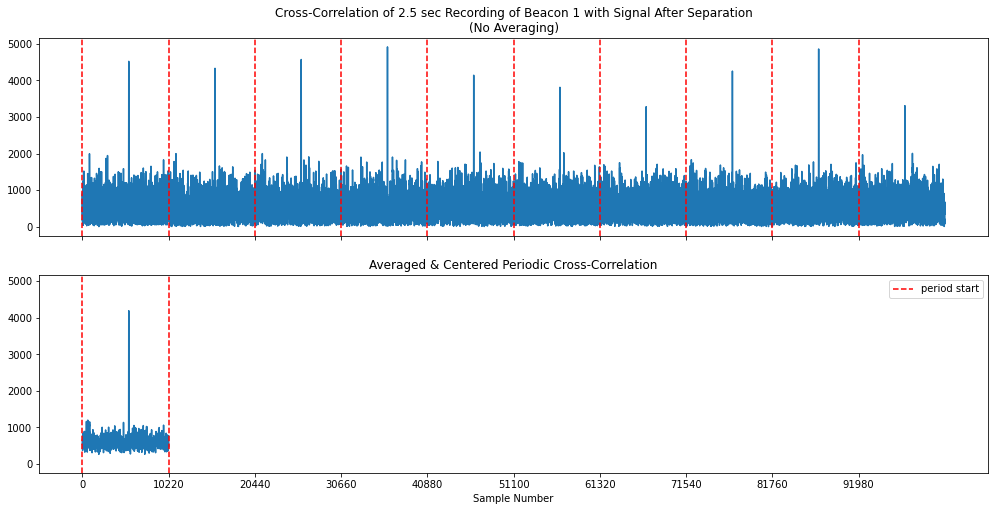

In [9]:
plot_average_multiple_signals()

**<span style="color:red">What is the effect of averaging? Why would this be useful?</span>**

As explained above, averaging helps us attenuate one-off outliers caused by noise. This can be seen above, as the unaveraged data contains noise hovering between magnitudes of 1000 and 2000. However, in the averaged sample, the noise is largely bounded by a magnitude of 1000.

<a id='task5'></a>
# <span style="color:blue">Task 5: Computing Distances</span>

Cross-correlation analysis allows us to determine the time delays between the arrivals of different beacon signals at the receiver. We need to determine a method to convert between these time delays and physical distances. To do so, we must first be able to convert the time delays in samples to real values of time. As previously discussed, the beacons begin transmitting at an unknown time. However, we can compute arrival times relative to a particular **reference beacon**, treating this beacon as having arrived at $t=\tau_0$. **<span style="color:red">Note that $\tau_0$ is to be treated as an unknown in our system, which we'll address later.</span>**

For example, we can choose **`beacon0`** to be the reference beacon. Then, the peak corresponding to **`beacon0`** is considered to be $t=\tau_0$. If the cross-correlation peak corresponding to **`beacon1`** occurs 300 samples after the **`beacon0`**, we can conclude that **`beacon1`** was received at $t=\tau_0 + 300$. 

The relative times of arrival (in units of samples) which we will call **offsets** are all defined  **offset** with respect to **`beacon0`** (or any other beacon of our choice). You can then convert offsets in samples to time delays in seconds at a known sampling frequency $f$ (this frequency determines the duration in seconds of each discrete time interval $T$). We'll abbreviate these time delays as TDOAs (time delays of arrival). More formally, if we denote each beacon's **absolute** time of arrival as $\tau_m$, each beacon's **TDOA** will be $\Delta \tau_m = \tau_m - \tau_0$.<br><br>

**<span style="color:red">According to our definition above what is the offset of `beacon0`?</span>**

By definition, beacon0 will have an offset of 0.

**<span style="color:red">If `beacon2` arrives 450 samples later than `beacon0`, what is the *time* difference of arrival (in seconds) given that our sampling rate is $f_s=44100$ Hz?</span>**  <br><br> **Hint: the formula $T = \frac{1}{f}$ will be useful**, where T and f are defined above.

450 samples divided by 44100 Hz (samples per second) yields ~0.01 seconds.

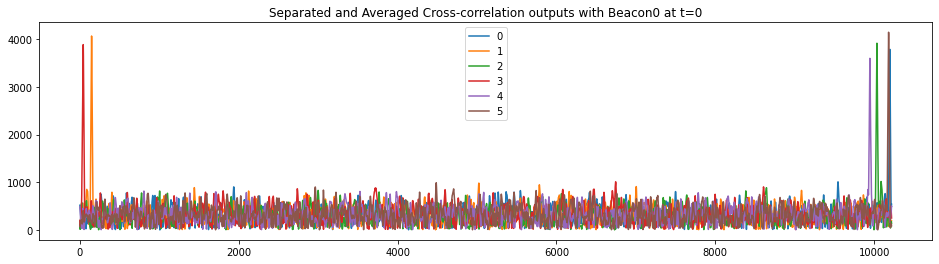

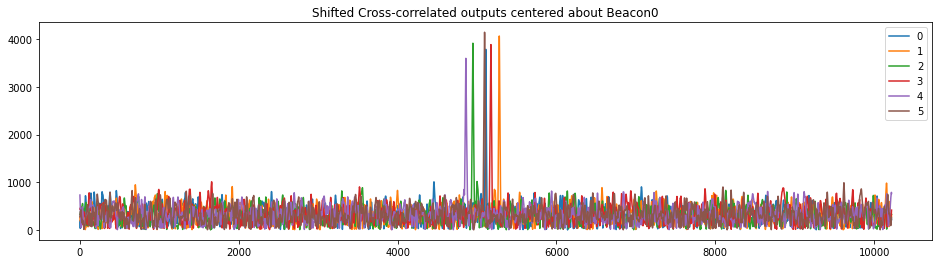

In [10]:
plot_shifted(identify_peak)

Note a beacon may arrive before our reference signal, if the first signal to arrive at the receiver was not chosen as the reference signal. These beacons have a negative offset. 

In the following exercises, you have been provided with code to center the received signal about the reference signal **`beacon0`** at sample 0 as above. You will need to complete the rest of each function as specified in the docstrings.

<a id='task5a'></a>
# <span style="color:blue">Task 5a: Identifying Offsets</span>

**<span style="color:red">Complete the function below which returns relative offsets (in units of samples) given a list of input signals.</span>**

In [11]:
def identify_offsets(averaged):
    """ Compute the offset (in units of samples) of each signal relative to the reference beacon by
    identifying the peak of each signal (absolute offset) and 
    subtracting the peak of the reference beacon's signal from it (relative offset).
    
    (The first line of code centers the signals about the peak corresponding to the reference beacon for you.)
    
    Functions to Use: identify_peak
    
    Args:
    averaged (list): the output of the average_multiple_signals() function (a list of single period cross correlated sigs)
    
    Returns (list): a list containing the offset of each input signal relative to the reference beacon (beacon0)
    """
    # Reshaping the input so that all of our signals are centered about the peak corresponding to beacon0
    shifted = [np.roll(avg, len(averaged[0]) // 2 - identify_peak(averaged[0])) for avg in averaged]
    beacon0_offset = identify_peak(shifted[0])

    # shifted:
    #     shifted is a list of shifted signals centered about the peak corresponding to beacon0 
    # beacon0_offset:
    #     The absolute offset that beacon0 starts at
    # YOUR TASK: Return a list of relative offsets (where each beacon starts relative to
    #            where beacon0 starts). This means that beacon0's offset should be 0.
    
    # Use `shifted` and `beacon0_offset` to determine the relative offsets of other beacons
    
    return [identify_peak(signal) - beacon0_offset for signal in shifted]

**<span style="color:red">Run the cell below to test `identify_offsets`. The two test cases may take a while to run but pay attention to the second test case!</span>**

In [12]:
test_identify_offsets(identify_offsets)

 ------------------ 
Test positive offsets
Your computed offsets = [0, 254, 114, 21, 153, 625]
Correct offsets = [0, 254, 114, 23, 153, 625]
Test 1 Passed
 ------------------ 
Test negative offsets
Your computed offsets = [0, -254, 0, -21, 153, -625]
Correct offsets = [0, -254, 0, -21, 153, -625]
Test 2 Passed


Now you must convert the offsets you just computed in samples to the time difference of arrivals (TDOAs) that will be used to determine relative distances.

**<span style="color:red">Given that the microphones sample at a rate of $f_s=44100$ Hz, complete the function `offset_to_tdoas` below, which takes a list of offsets and a sampling frequency, and returns a list of TDOA's.</span>**
<br/>
*Hint: What is the relationship between sampling frequency, number of samples, and time?*

In [14]:
def offsets_to_tdoas(offsets, sampling_freq):
    """ Convert a list of offsets to a list of TDOA's
   
    Args:
    offsets (list): list of offsets in samples
    sampling_freq (int): sampling frequency in Hz
    
    Returns (list): a list of TDOAs corresponding to the input offsets
    """
    return [offset / sampling_freq for offset in offsets]

**<span style="color:red">Run the cell below to test `offsets_to_tdoas`.</span>**

In [15]:
test_offsets_to_tdoas(offsets_to_tdoas)

 ------------------ 
Test TDOAs
Your computed TDOAs = [ 0.       -0.00576   0.       -0.000476  0.003469 -0.014172]
Correct TDOAs = [ 0.       -0.00576   0.       -0.000476  0.003469 -0.014172]
Test Passed


<a id='task5b'></a>
# <span style="color:blue">Task 5b: Combining Functions</span>
You have written a variety of helper functions to perform each step of the processing required to go from the received signal at the microphone to a list of TDOAs. You will now consolidate these steps into one convenient method.

**<span style="color:red">Implement a function that will take in the recorded microphone signal and output the TDOAs of each beacon.</span>**

In [16]:
def signal_to_tdoas(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker.
    
    Functions to use: separate_signal, average_multiple_signals, identify_offsets, offsets_to_tdoas
    
    Args:
    raw_signal (np.array): raw received signal from the microphone (e.g. no separation, averaging, etc).
    
    Returns (list): TDOA for each beacon (beacon0, beacon1, etc).
    """
    sampling_freq = 44100
    separated_signals = separate_signal(raw_signal) #first compute appropriate cross-correlations
    periodwise_averages = average_multiple_signals(separated_signals) #then perform period-wise averaging
    offsets = identify_offsets (periodwise_averages) #extract the offets per beacon
    return offsets_to_tdoas(offsets, sampling_freq) #convert the offsets to TDOAs

**<span style="color:red">Run the cell below to test `signal_to_tdoas`. DO NOT move on before passing this test.</span>**

In [17]:
test_signal_to_tdoas(signal_to_tdoas)

 ------------------ 
Test computed distances
Your computed distances = [ 0.          0.00290249 -0.00088435  0.0022449  -0.00424036 -0.00126984]
Correct distances = [ 0.          0.00290249 -0.00088435  0.0022449  -0.00424036 -0.00126984]
Test Passed


<a id='task6'></a>
# <span style="color:blue">Task 6: Constructing and Solving a System of Equations </span>

Now that we have the TDOAs from each beacon, we can construct a system of equations using the distance forumla to solve for our unknowns and then use least squares to approximate a solution! **IMPORTANT: some portions of this section will run slowly due to task complexity and limited computational power on datahub.**

<a id='task6a'></a>
# <span style="color:blue">Task 6a: Constructing the System </span>

Suppose we have $M$ beacons $\vec{a}_0,~\vec{a}_1,~\cdots,~\vec{a}_{M - 1}$, so the position of a beacon $\vec{a}_i$ in the 2-D plane will be $\vec{a}_i = [a_{i,x}, a_{i ,y}]^T$. These positions are known. We also have a receiver $\vec{r}$ with unknown position $\vec{r}=[r_x, r_y]^T$ in the same plane. Let $d_i$ denote the distance of $a_i$ to $\vec{r}$, $d_i = \sqrt{(r_x - a_{i, x})^2 + (r_y - a_{i, y})^2}$. 

For simplification, in this lab we set the first beacon $\vec{a}_0$ at position (0, 0), as a reference. We also let $\tau_0$, $\tau_1$ ... $\tau_{m - 1}$ denote the absolute times of arrival. Since we are referencing all the beacons to the  first beacon, we also define the TDOAs $\Delta\tau_i = \tau_i - \tau_0 $. 

In Task 5, you wrote a function that allows you to determine the TDOAs from the signal recorded by the receiver. We need the absolute times of arrival to determine the distance from each beacon to the receiver. As such, we need to treat $\tau_0$ as an unknown. 

From $M$ number of beacons, we have $M$ equations for $0\leq i<M$:
$$ \Vert \vec{r}- a_i \Vert ^2 = d_i^2 $$

Expanding the norm, and substituting for $d_i=v_s\tau_i$ where $v_s$ is the speed of sound, we get:

$$ \Vert \vec{r} \Vert^2 - 2\vec{a}_i^T\vec{r} + \Vert \vec{a}_i \Vert^2 = v_s^2\tau_i^2 $$

We can get rid of the quadratic term $\Vert \vec{r} \Vert^2$ by subracting each $i^\mathrm{th}$ equation with the first equation ($i=0$):

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2(\tau_i-\tau_0)^2 $$

Expanding $(\tau_i-\tau_0)^2 =  (\tau_i-\tau_0)(\tau_i+\tau_0)  =  (\tau_i-\tau_0)(\tau_i-\tau_0+2\tau_0) = \Delta\tau_i (\Delta \tau_i + 2\tau_0)$ we express the argument in terms of the measured time differences $\Delta \tau_i$ and the unknown $\tau_0$, and get:

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2\Delta \tau_i(\Delta \tau_i + 2\tau_0) $$

Rearranging, we get a linear set of equation w.r.t $\vec{r}$ and $\tau_0$!

$$ 2(\vec{a}_0-\vec{a}_i)^T\vec{r} - 2(v_s^2\Delta \tau_i)\tau_0 = \Vert \vec{a}_0 \Vert^2 - \Vert \vec{a}_i \Vert^2 + v_s^2\Delta \tau_i^2 $$

And explicitly expanding the variables $r_x,~r_y,~\tau_0$, and substituting $\vec{a}_0 = [0,0]^T$:

$$ -2a_{i,x}r_{x} - 2a_{i,y}r_y - 2(v_s^2\Delta \tau_i) \tau_0 = -a_{i,x}^2 - a_{i,y}^2 + v_s^2 \Delta \tau_i^2 $$

Negating we get the final result 

$$ 2a_{i,x}\color{red}{r_{x}} + 2a_{i,y}\color{red}{r_y} + 2v_s^2\Delta \tau_i \color{red}{\tau_0} = a_{i,x}^2  +a_{i,y}^2 - v_s^2 \Delta \tau_i^2 $$

which are M-1 equations (since we used equation i=0), for $1\leq i < M$.

**<span style="color:red">What are the unknowns in the system above?</span>**

We don't know the position of the receiver or the offset of beacon0. As such, rx, ry, and t0 are the unknowns.

Below is the same equation written out as a matrix for a system that has $M$ speakers. $r_x$ and $r_y$ are the coordinates of your speaker that you would like to solve for, and $\tau_0$ is the arrival time of beacon 0.

$$ 2 \left [
\begin{matrix}
    a_{1,x}  & a_{1,y} & v_s^2\Delta \tau_1 \\
    a_{2,x}  & a_{2,y} & v_s^2\Delta \tau_2 \\
    &\vdots & \\
    a_{M-1,x}  & a_{M-1,y} & v_s^2\Delta \tau_{M-1}
\end{matrix}
\right] 
\left [
\begin{matrix} 
    r_x\\ r_y \\ \tau_0
\end{matrix}
\right]
=
\left [
\begin{matrix}
    a_{1,x}^2  +a_{1,y}^2 - v_s^2 \Delta \tau_1^2 \\
    a_{2,x}^2  +a_{2,y}^2 - v_s^2 \Delta \tau_2^2 \\
    \vdots  \\
    a_{M-1,x}^2  +a_{M-1,y}^2 - v_s^2 \Delta \tau_{M-1}^2
\end{matrix}
\right]
$$

**<span style="color:red">
What is the minimum number of beacons we need in order to be able to recover a position from our system?
</span>**

We have 3 unknowns, so we need 3 equations. As we have seen, M becaons produce M-1 equations, so we need 4 beacons.

**<span style="color:red">
What is the minimum number of rows that the matrix requires for this system to be solvable? Understanding how Linear Least Squares works, do we want more or exactly that many rows to get an accurate reading of our position?
</span>**

For the system to be exactly solvable, the matrix needs 3 rows. However, we'd like as much redundancy as possible to make our system more accurate, so we want more rows.

For your convenience, we've provided a function to construct the above system for the purpose of least squares:

In [18]:
def construct_system(speakers, TDOA, v_s):
    """Construct the components of the system according to a list of TDOAs and speaker coordinates
    Args:
    speakers (np.array): an array of speaker coordinates
    TDOA (np.array): an array of relative TDOA's
    
    Returns:
    A (np.array): the matrix corresponding to the least squares system
    b (np.array): the vector corresponding to the least squares system
    
    """
    
    # Initialize A matrix with zeroes
    A = np.zeros((speakers.shape[0]-1,3))
    # Set the first two columns of A to positions of beacons
    A[:,:2] = speakers[1:]
    # Calculate and set the last column of A from TDOAs
    A[:,2] = v_s*v_s*TDOA[1:]
    # Add the scalar multiple of 2 in front
    A = A*2

    # Calculate the b vector
    # (np.sum is horizontally summing the squared positions)
    b = np.sum(speakers[1:,:] * speakers[1:,:],axis=1) - v_s*v_s*TDOA[1:]*TDOA[1:]

    return np.array(A), np.array(b)

<a id='task6b'></a>
# <span style="color:blue">Task 6b: Approximating a Solution with Least Squares </span>

**Definition**: If $A$ is an $m \times n$ matrix and $\vec{b}$ is in $\mathbb{R}^m$, a **least squares solution** of $A\vec{x}=\vec{b}$ is an $\hat{\vec{x}}$ in $\mathbb{R}^n$ such that for all $\vec{x}$ in $\mathbb{R}^n$: $||\vec{b} - A\hat{\vec{x}}|| \leq ||\vec{b} - A\vec{x}||$.

The solution for an overdetermined problem is given by solving the normal equations: $A^TA\vec{x}=A^T\vec{b}$.

For more on least squares, here's a link to [Note 23](https://eecs16a.org/lecture/Note23.pdf).

**Why do we need least squares here?**

During the transmission of sound in air, some noise is added into the signal. Most of the time we don't receive the original signal perfectly; in other words, the linear system is no longer consistent due to the modified signal. Also in our positioning system, we have more than 2 linear equations to improve the accuracy. However with more equations, the linear system is more likely to be inconsistent. Least squares solution ensures a best approximation we can get, even if there is technically no solution to the system.

**<span style="color:red">Implement the following function given arguments matrix A and vector b. Implement your own function for solving least squares, do not use the least squares solver built into python. Make sure your code passes the test before moving on.</span>**

In [19]:
def least_squares(A, b):
    """Solve the least squares problem
    
    Args:
    A (np.array): the matrix in the least squares problem
    b (np.array): the vector in the least squares problem
    
    Returns:
    pos (np.array): the result of the least squares problem (x)    
    """

    return np.linalg.inv(A.T @ A) @ A.T @ b

**<span style="color:red">Test your code with noisy inputs by running the following block. Are all of the estimates in the cases with noise reasonable? Why or why not?</span>**
(This will take a while to compute. Don't worry if there are some small errors on the order of +/- 0.1)

In [20]:
# Testing signals with noise
test_loc(least_squares, construct_system, 1.2, 3.6, 30)
test_loc(least_squares, construct_system, 1.2, 3.6, 40)
test_loc(least_squares, construct_system, 1.2, 3.6, 50)

Expected: (1.200, 3.600); got (1.194, 3.605)

Expected: (1.200, 3.600); got (1.194, 3.605)

Expected: (1.200, 3.600); got (1.194, 3.605)



<a id='task6c'></a>
# <span style="color:blue">Task 6c: Simulation Testing </span>

**<span style="color:red">You will go through a simulation to ensure that your code is working for a stable, slightly noisy simulation. Run the code below to test your code against our test signal. Your calculated position should be decently close to where we have placed the microphone. </span>**

Least Squares Microphone Position: 0.0442, 0.3636, time-offset: 0.0009
Actual Microphone Position: 0.0000, 0.4000
Calcuated Distances from Beacons : [0.3662, 0.6286, 0.6363, 0.5437, 0.1425, 0.0807]



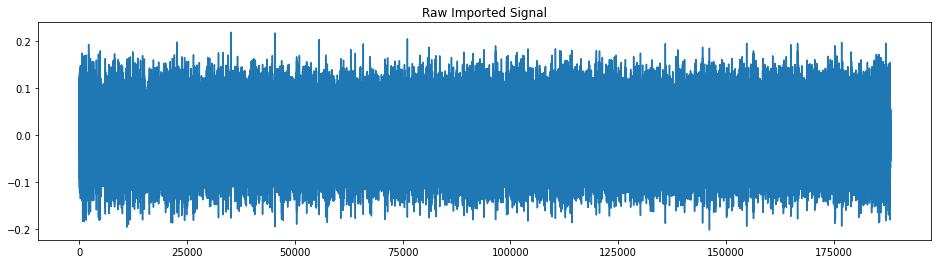

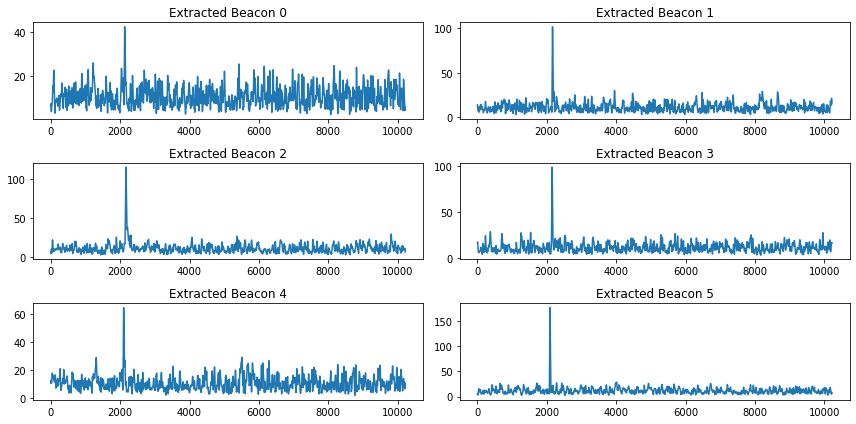

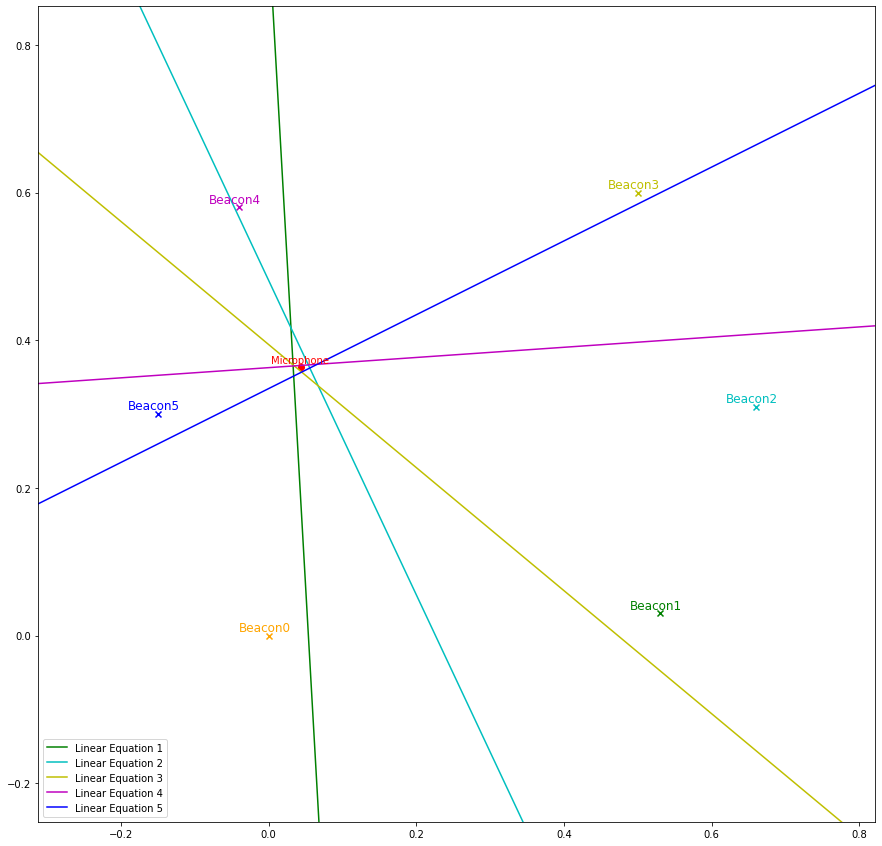

In [21]:
Lab = APS('new_data.npy', [0, 40], ms= True)
Lab.simulation_testing('APS_Recording/test-signal.wav', construct_system, least_squares, signal_to_tdoas)

## **Congratulations!**
You have successfully located a microphone using techniques such as cross-correlation, multilateration and least squares.

Kudos for making it through all the EECS16A labs. We hope you had a great time. Good luck for the of your journey through EECS. Bon voyage!

<a id='checkoff'></a>
## Checkoff
This lab is **optional**, so there's no checkoff! Stay tuned for the solutions during RRR week.